# TDDE16 Machine learning for spam detection



In [21]:
from copy import deepcopy

import numpy as np
import pandas as pd

df=pd.read_csv("mail_data.csv", encoding="latin-1")


In [22]:
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


### Dataset balance graph
This plot shows the number of spam mails in contrast with legitimate mails.\
1 signifies spam and 0 legitimate. The dataset is fairly balanced with 53% spam and 47% legit mails making it a decent dataset to train on.


       Count  Percentage (%)
label                       
1      43910       52.619595
0      39538       47.380405


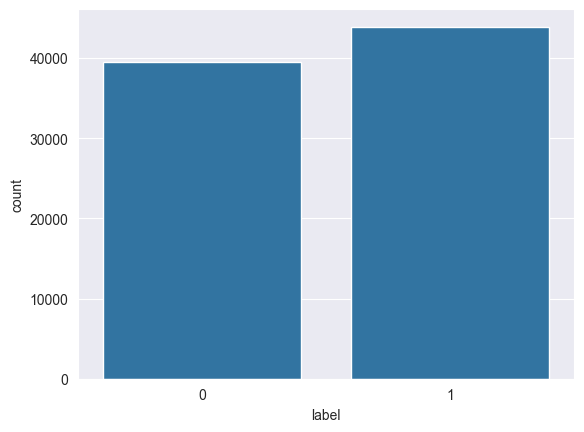

In [23]:
import seaborn as sns

sns.countplot(x="label", data=df)

counts = df['label'].value_counts()
percentages = (counts / counts.sum()) * 100

summary = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages})
print(summary)

### Plotting the average length of an email
On average it seems like spam mails are longer than legitimate mails.\
Generally legit emails are short and concise enough to convey the intended message without any equivocation.

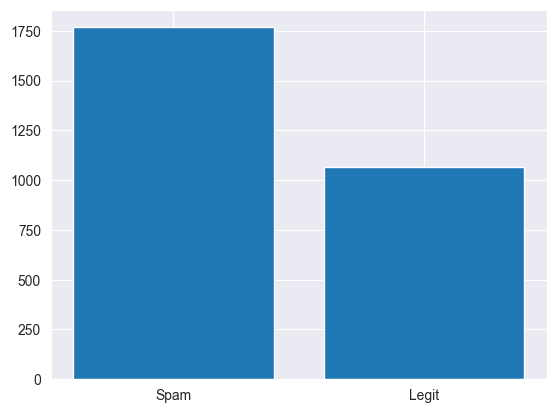

In [24]:
from numpy import mean
import matplotlib.pyplot as plt
spam_lengths = []
ham_lengths = []
for label, group in df.groupby('label'):
    for text in group.text:
        if label == 0:
            spam_lengths.append(len(text.replace(' ', '')))
        elif label == 1:
            ham_lengths.append(len(text.replace(' ', '')))

means = [mean(spam_lengths), mean(ham_lengths)]

labels = ['Spam', 'Legit']
plt.bar(labels, means)
plt.show()

### Preprocess data
Before the dataset can be used, we want to preproccess the text fields by removing special characters, removing stop words and perform lemmatization.\
This will be required to isolate important words that do not clutter the dataset. Two commonly occuring words are removed: "escapenumberd" "escapelong".\
Probably escape characters that were accidently translated into strings.

In [25]:
import spacy
nlp = spacy.load('en_core_web_sm')

def preprocess(df, num=None, removal_words=None):
    if removal_words is None:
        removal_words = []

    if num is None:
        num = len(df)

    texts = []
    labels = []

    for i, data in df.head(num).iterrows():
        text = ""
        for doc in nlp(data.text):
            if not doc.is_stop and doc.text not in removal_words and doc.is_alpha and "escapenumber" not in doc.text:
                text += " " + doc.lemma_
        texts.append(text)
        labels.append(data.label)

    return texts, labels

In [26]:
escape_words = ["escapenumberd", "escapelong", "escapenumber"]
texts, labels = preprocess(df, 5000, removal_words=escape_words)

cleaned_df = pd.DataFrame({'label': labels, 'text': texts})
cleaned_df

,label,text
0,1,ounce feather bowl hummingbird opec moment al...
1,1,wulvob medircation online qnb ikud viagra lev...
2,0,computer connection cnn com wednesday pm edt ...
3,1,university degree obtain prosperous future mo...
4,0,thank answer guy know check rsync manual sure...
...,...,...
4995,1,good morning offer late oem package graphic p...
4996,0,internet home home news market technology job...
4997,1,lakjsdf
4998,1,like oh dear yes sit smile admire explain unt...


In [27]:
from collections import Counter

def rank_words_by_label(df):
    all_words = []
    counts = []
    labels = []
    for label, group in (df.groupby('label')):
        text_words = []
        for text in group.iterrows():
            words = text[1].text.split()
            text_words.extend(words)

        word_counter = Counter(text_words)
        for word, count in word_counter.most_common():
            all_words.append(word)
            counts.append(count)
            labels.append(label)


    return pd.DataFrame({"label": labels, "word": all_words, "count": counts})

ranks = rank_words_by_label(cleaned_df)



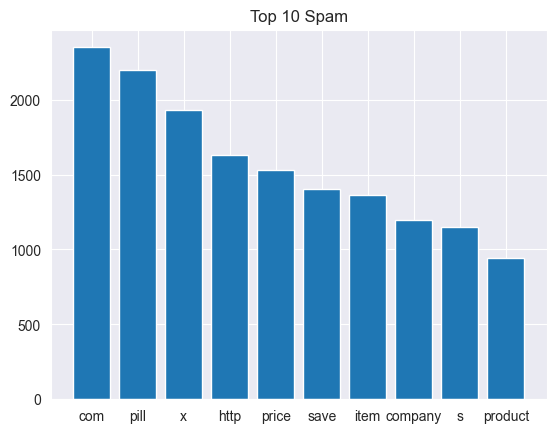

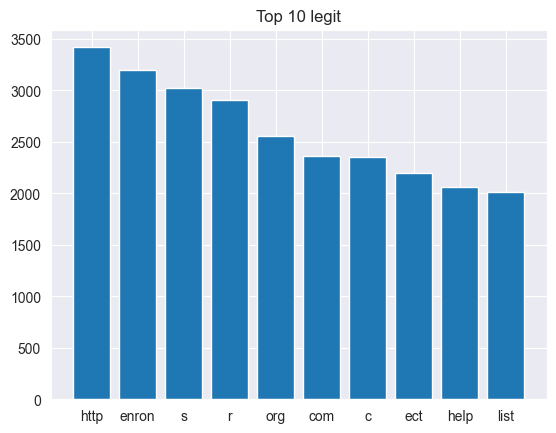

In [28]:
spam = ranks[ranks['label'] == 1]
legit = ranks[ranks['label'] == 0]

top_spam = spam[:10]
top_legit = legit[:10]

spam_labels = [word for word in top_spam['word']]
spam_counts = [count for count in top_spam['count']]
plt.bar(spam_labels, spam_counts)
plt.title('Top 10 Spam')
plt.show()

legit_labels = [word for word in top_legit['word']]
legit_counts = [count for count in top_legit['count']]
plt.title('Top 10 legit')
plt.bar(legit_labels, legit_counts)
plt.show()

### Counting words
As expected, the number of words is greater in the spam mails in comparison to legit ones.\
This conclusion can already be taken at the character analysis, more chars equals more words.

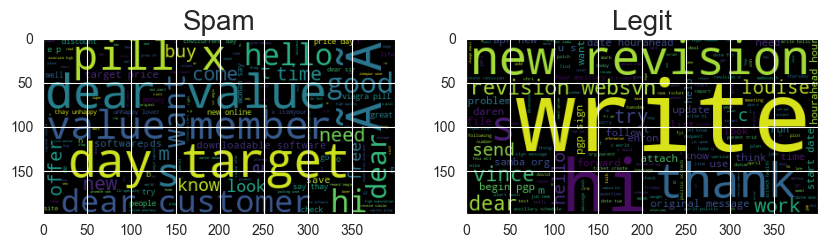

In [29]:
from wordcloud import WordCloud

spam_words = cleaned_df.text.where(cleaned_df.label == 1).dropna()
legit_words = cleaned_df.text.where(cleaned_df.label == 0).dropna()

wordcloud_spam = WordCloud().generate(spam_words.to_string())
wordcloud_legit = WordCloud().generate(legit_words.to_string())

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title("Spam", fontsize=20)
plt.imshow(wordcloud_spam)

plt.subplot(1, 2, 2)
plt.title("Legit", fontsize=20)
plt.imshow(wordcloud_legit)

plt.show()

### Wordclouds
We can clearly see that spam mails consist of words such as "value", "member", "pill", "price" and "time".\
These words are often used to grab attention of the reader. Both datasets contain the word "dear" and "hello".\
These are typical greeting words used in all types of messages and is harder to derive any context from.


Average words in spam: 365.05928473873234 
Average words in legit: 208.98250967888865


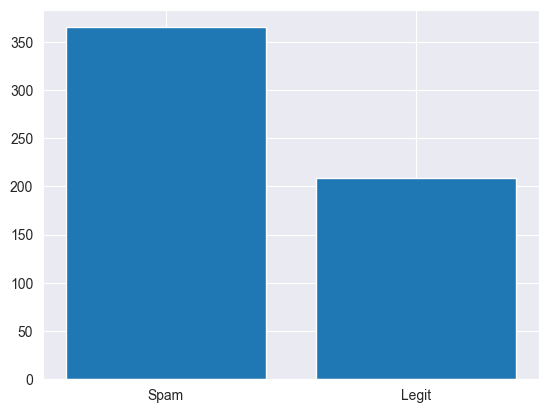

In [30]:
spam_words = []
ham_words = []

for label, group in df.groupby('label'):
    for text in group.text:
        if label == 0:
            spam_words.append(len(text.split()))
        elif label == 1:
            ham_words.append(len(text.split()))

means = [mean(spam_words), mean(ham_words)]
labels = ['Spam', 'Legit']
print(f"Average words in spam: {means[0]} \n"
      f"Average words in legit: {means[1]}")
plt.bar(labels, means)
plt.show()

### Testing different classifiers
In this section three classifiers will be tested and compared.
1. Naive bayes
2. Decision Tree
3. Logistic Regression

Two evaluations will be done, one with character and word count and one without.



In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from copy import deepcopy
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer()

X = cleaned_df.text
y = cleaned_df.label

# using char and word count
count_df = deepcopy(df)
count_df['char_length'] = count_df['text'].apply(len)
count_df['word_count'] = count_df['text'].apply(lambda x: len(x.split()))

preprocessor = ColumnTransformer([
    ('countvectorizer', vectorizer, 'text'),
    ('scaler', MinMaxScaler(), ['char_length', 'word_count'])
])

X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(count_df[['text', 'char_length', 'word_count']], count_df['label'], test_size=0.2)

#

### Naive bayes (No Count)

In [32]:
from sklearn.naive_bayes import MultinomialNB
X_vec = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2)

naive_classifier = MultinomialNB().fit(X_train, y_train)
y_pred = naive_classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Legit', 'Spam']))

              precision    recall  f1-score   support

       Legit       0.93      0.99      0.96       476
        Spam       0.99      0.94      0.96       524

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



### Naive bayes (Count)

In [33]:
from sklearn.naive_bayes import MultinomialNB

pipeline_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

naive_classifier = pipeline_nb.fit(X_train_count, y_train_count)
y_pred = naive_classifier.predict(X_test_count)
print(classification_report(y_test_count, y_pred, target_names=['Legit', 'Spam']))

              precision    recall  f1-score   support

       Legit       0.96      0.98      0.97      7790
        Spam       0.99      0.97      0.98      8900

    accuracy                           0.97     16690
   macro avg       0.97      0.98      0.97     16690
weighted avg       0.97      0.97      0.97     16690



### Decision Tree (No count)

In [34]:
from sklearn.tree import DecisionTreeClassifier

X_vec = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2)

dt_classifier = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Legit', 'Spam']))

              precision    recall  f1-score   support

       Legit       0.88      0.93      0.90       467
        Spam       0.93      0.89      0.91       533

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



Naive bayes seem to perform much better using word and character count.

### Decision Tree (Count)

In [35]:
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])
dt_classifier = pipeline_dt.fit(X_train_count, y_train_count)
y_pred = dt_classifier.predict(X_test_count)

print(classification_report(y_test_count, y_pred, target_names=['Legit', 'Spam']))

              precision    recall  f1-score   support

       Legit       0.96      0.96      0.96      7790
        Spam       0.97      0.97      0.97      8900

    accuracy                           0.96     16690
   macro avg       0.96      0.96      0.96     16690
weighted avg       0.96      0.96      0.96     16690



 ### Logistical Regression (No count)

In [36]:
from sklearn.linear_model import LogisticRegression

X_vec = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2)

lr_classifier = LogisticRegression().fit(X_train, y_train)
y_pred = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Legit', 'Spam']))

              precision    recall  f1-score   support

       Legit       0.99      0.96      0.98       473
        Spam       0.97      0.99      0.98       527

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



### Logisitcal Regression (Count)

In [37]:
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
lr_classifier = pipeline_lr.fit(X_train_count, y_train_count)
y_pred = lr_classifier.predict(X_test_count)

print(classification_report(y_test_count, y_pred, target_names=['Legit', 'Spam']))

              precision    recall  f1-score   support

       Legit       0.99      0.98      0.99      7790
        Spam       0.99      0.99      0.99      8900

    accuracy                           0.99     16690
   macro avg       0.99      0.99      0.99     16690
weighted avg       0.99      0.99      0.99     16690



### Testing on new dataset
This is a new dataset that is unbalanced.

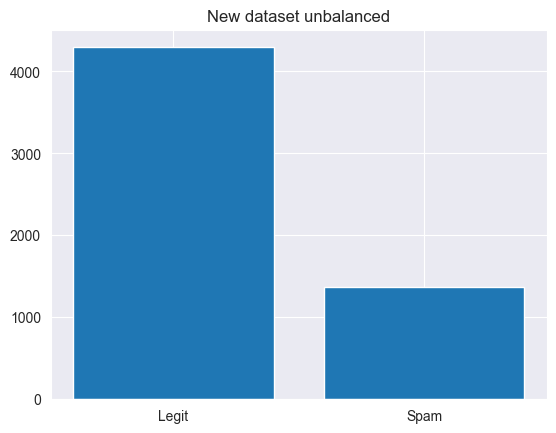

C:\Users\chudyr\AppData\Local\Temp\ipykernel_33092\3498530938.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spam_count = balanced_df[test_df["label"] == 1].value_counts().value_counts().iloc[0]
C:\Users\chudyr\AppData\Local\Temp\ipykernel_33092\3498530938.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  legit_count = balanced_df[test_df["label"] == 0].value_counts().value_counts().iloc[0]


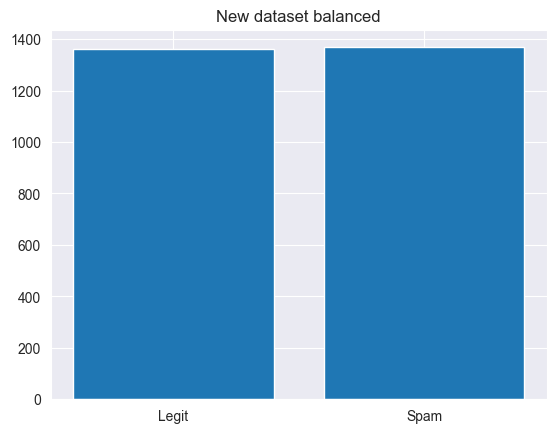

In [38]:
from sklearn.utils import resample

test_df=pd.read_csv("emails.csv")
test_df.rename(columns={"spam": "label"}, inplace=True)
spam_list = test_df.text.tolist()

spam_count = test_df[test_df["label"] == 1].value_counts().value_counts().iloc[0]
legit_count = test_df[test_df["label"] == 0].value_counts().value_counts().iloc[0]

labels = ["Legit", "Spam"]
data = [legit_count, spam_count]

plt.bar(labels, data)
plt.title("New dataset unbalanced")
plt.show()

legit_under_sampled = resample(test_df[test_df["label"]==0], replace=False, n_samples=spam_count)
balanced_data = [legit_under_sampled, test_df[test_df["label"]==1]]
balanced_df = pd.concat(balanced_data)

spam_count = balanced_df[test_df["label"] == 1].value_counts().value_counts().iloc[0]
legit_count = balanced_df[test_df["label"] == 0].value_counts().value_counts().iloc[0]

data = [legit_count, spam_count]
labels = ["Legit", "Spam"]

plt.bar(labels, data)
plt.title("New dataset balanced")
plt.show()

### Evaluation on new data
Here the classifiers are tested on a new dataset. The original data is unbalanced and is later undersampled to be balanced.

### Unbalanced

In [39]:
shuffled_df = test_df.sample(frac=1).reset_index(drop=True)
texts, labels = preprocess(shuffled_df, 1000, removal_words=["subject"])

In [40]:
preprocessed_df = pd.DataFrame({'label': labels, 'text': texts})
golden_y = labels

count_df = deepcopy(preprocessed_df)
count_df['char_length'] = count_df['text'].apply(len)
count_df['word_count'] = count_df['text'].apply(lambda x: len(x.split()))

nb_pred = naive_classifier.predict(count_df)
dt_pred = dt_classifier.predict(count_df)
lr_pred = lr_classifier.predict(count_df)

print("=================== Naive Bayes ==========================")
print(classification_report(golden_y, nb_pred, target_names=['Legit', 'Spam']))
print("=================== Decision Tree ========================")
print(classification_report(golden_y, dt_pred, target_names=['Legit', 'Spam']))
print("=================== Logistic Regression ==================")
print(classification_report(golden_y, lr_pred, target_names=['Legit', 'Spam']))
print("==========================================================")

=================== Naive Bayes ==========================
              precision    recall  f1-score   support

       Legit       0.98      0.99      0.99       761
        Spam       0.98      0.94      0.96       239

    accuracy                           0.98      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.98      0.98      1000

=================== Decision Tree ========================
              precision    recall  f1-score   support

       Legit       0.98      0.90      0.94       761
        Spam       0.76      0.94      0.84       239

    accuracy                           0.91      1000
   macro avg       0.87      0.92      0.89      1000
weighted avg       0.93      0.91      0.92      1000

=================== Logistic Regression ==================
              precision    recall  f1-score   support

       Legit       1.00      0.97      0.98       761
        Spam       0.91      1.00      0.95       239

    a

### Balanced

In [41]:
balanced_df.reset_index(drop=True, inplace=True)

In [42]:
preprocessed_df = pd.DataFrame({'label': labels, 'text': texts})
shuffled_balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
golden_y = shuffled_balanced_df["label"].tolist()

count_df = deepcopy(shuffled_balanced_df)
count_df['char_length'] = count_df['text'].apply(len)
count_df['word_count'] = count_df['text'].apply(lambda x: len(x.split()))

nb_pred = naive_classifier.predict(count_df)
dt_pred = dt_classifier.predict(count_df)
lr_pred = lr_classifier.predict(count_df)

print("=================== Naive Bayes ==========================")
print(classification_report(golden_y, nb_pred, target_names=['Legit', 'Spam']))
print("=================== Decision Tree ========================")
print(classification_report(golden_y, dt_pred, target_names=['Legit', 'Spam']))
print("=================== Logistic Regression ==================")
print(classification_report(golden_y, lr_pred, target_names=['Legit', 'Spam']))
print("==========================================================")


=================== Naive Bayes ==========================
              precision    recall  f1-score   support

       Legit       0.97      0.99      0.98      1368
        Spam       0.99      0.97      0.98      1368

    accuracy                           0.98      2736
   macro avg       0.98      0.98      0.98      2736
weighted avg       0.98      0.98      0.98      2736

=================== Decision Tree ========================
              precision    recall  f1-score   support

       Legit       0.99      0.99      0.99      1368
        Spam       0.99      0.99      0.99      1368

    accuracy                           0.99      2736
   macro avg       0.99      0.99      0.99      2736
weighted avg       0.99      0.99      0.99      2736

=================== Logistic Regression ==================
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00      1368
        Spam       1.00      1.00      1.00      1368

    a

### Conclusion
Incorporating word and character count improved the model by a decent amount.

The three classifiers work very well on balanced and unbalanced datasets.
For the balanced dataset accuracy was near 1 for every classifier.

For the unbalanced dataset it had some minor issues identifying the minority class but still performed well.
This means that the model is able to better distinguish between spam and legitimate and does not only guess legit (Majority class) for a false high precision.
